In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import uuid
from graphviz import Source
from itertools import chain

In [78]:
class Node:
    def __init__(self):
        self.id = uuid.uuid1()


class InputNode(Node):
    def __init__(self, var_id):
        super().__init__()
        self.var_id = var_id
        self.children = []


class AndNode(Node):
    def __init__(self, var_id):
        super().__init__()
        self.var_id = var_id
        self.is_output = False
        self.parents = []
        self.children = []


class NodeNetwork:
    def __init__(self, num_inputs, hidden_layers, num_outputs):
        self.num_inputs = num_inputs
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs
        self.max_var_idx = 0
        self.nodes_ = []

        for i in range(len(self.hidden_layers) + 1):
            if i == 0:
                input_nodes = []
                for i in range(num_inputs):
                    self.max_var_idx += 1
                    inp_node = InputNode(self.max_var_idx)
                    inp_node.loc = (0, i)
                    input_nodes.append(inp_node)
                self.nodes_.append(input_nodes)
            else:
                and_nodes = []
                for j in range(self.hidden_layers[i - 1]):
                    self.max_var_idx += 1
                    and_node = AndNode(self.max_var_idx)
                    and_node.loc = (i, j)
                    k = 0
                    while len(and_node.parents) < 2:
                        candidate_parent = list(chain(*self.nodes_))[k % len(list(chain(*self.nodes_)))]
                        if (
                            (
                                len(candidate_parent.children)
                                == 0 # if candidate has no children at all, take for sure
                                or np.random.choice([True, False], p=[1 / (2 + 2 * j), 1 - 1 / (2 + 2 * j)])
                            )
                            and candidate_parent.loc
                            not in and_node.parents
                        ):
                            and_node.parents.append(
                                candidate_parent.loc
                            )
                            candidate_parent.children.append(
                                and_node.loc
                            )
                        k += 1
                    and_node.negate_0 = random.choice([True, False])
                    and_node.negate_1 = random.choice([True, False])
                    
                    and_nodes.append(and_node)
                self.nodes_.append(and_nodes)
        # Currently only last layer nodes are outputs
        for node in self.nodes_[-1]:
            node.is_output = True

In [94]:
nn = NodeNetwork(4, [3, 3, 2], 2)

# File header
out_str = (
    f"aag {nn.max_var_idx} {nn.num_inputs} 0 {nn.num_outputs} {sum(nn.hidden_layers)}\n"
)

# Input nodes
for node in nn.nodes_[0]:
    out_str += f"{node.var_id * 2}\n"

# Output nodes
for node in nn.nodes_[-1]:
    out_str += f"{node.var_id * 2}\n"


for i in range(len(nn.nodes_)):
    if i == 0:
        continue
    for upper_node in nn.nodes_[i]:
        idx00 = upper_node.parents[0][0]
        idx01 = upper_node.parents[0][1]
        idx10 = upper_node.parents[1][0]
        idx11 = upper_node.parents[1][1]
        p0 = f"{(nn.nodes_[idx00][idx01].var_id * 2) + upper_node.negate_0}"
        p1 = f"{(nn.nodes_[idx10][idx11].var_id * 2) + upper_node.negate_1}"
        out_str += f"{2 * upper_node.var_id} {p0} {p1}\n"

# print(out_str)
with open(r"tmp_aig.aag", "w") as f:
    f.write(out_str)

In [95]:
%%capture aig_dot
!aiger/aigtodot tmp_aig.aag

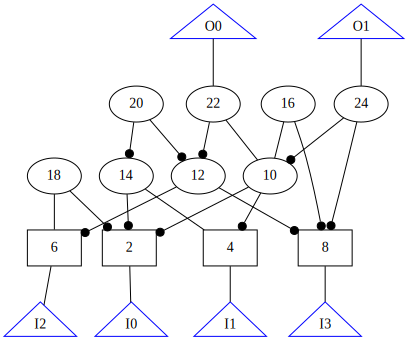

In [96]:
s = Source(aig_dot.stdout, filename="test", format="png")
s